# Fix Irregularities in the data

### Check inconsistencies with the data

Loading CSV: 100%|██████████| 1157172/1157172 [00:01<00:00, 1097940.64rows/s]


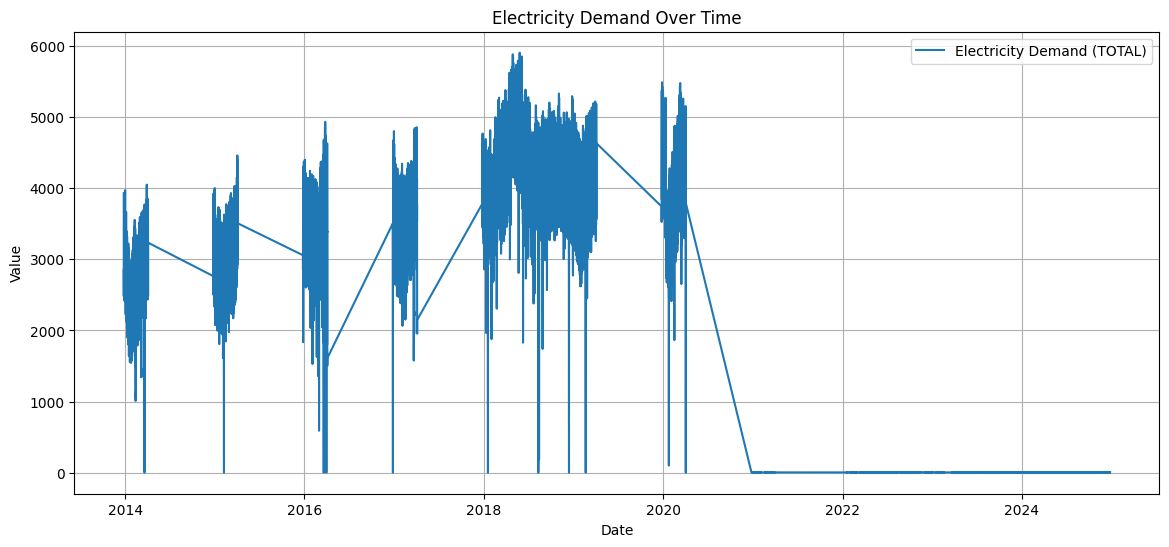

In [58]:
# Plot Electricity Demand (TOTAL) from demand csv

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# File path
file_path = "tmp/Demand.csv"
chunksize = 10_000  

# Count rows first (excluding header)
with open(file_path) as f:
    total_rows = sum(1 for _ in f) - 1


# Load with progress bar
chunks = []
with tqdm(total=total_rows, desc="Loading CSV", unit="rows") as pbar:
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)

# --- Handle different formats ---
if "DateTime" in df.columns:
    df["DateTime"] = pd.to_datetime(df["DateTime"], format="mixed", errors="coerce")
    df.set_index("DateTime", inplace=True)
elif "Metering Point" in df.columns:
    df["Metering Point"] = pd.to_datetime(df["Metering Point"], format="mixed", errors="coerce")
    df.set_index("Metering Point", inplace=True)


# Drop unnamed index column if exists
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# --- Plot ---
plt.figure(figsize=(14,6))
plt.plot(df.index, df["TOTAL"], label="Electricity Demand (TOTAL)", color="tab:blue")

# Plot Temperature only if it exists
if "Temperature" in df.columns:
    plt.plot(df.index, df["Temperature"], label="Temperature", color="tab:orange", alpha=0.7)

plt.title("Electricity Demand Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


Loading CSV: 100%|██████████| 1157172/1157172 [00:01<00:00, 883890.83rows/s]


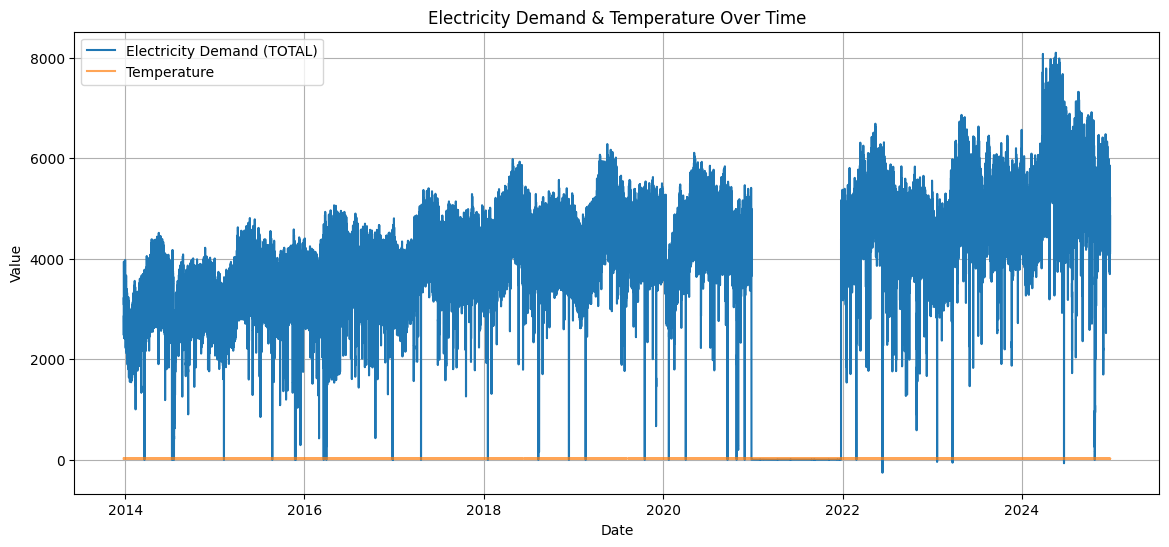

In [59]:
# Plot Demand and temp from Demand_with_Temperature.csv before fixing inconsistency from demand
# There's a period from the demand that was not converted to Kilowatts from Megawatts

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# File path
file_path = "tmp/Demand_with_Temperature.csv"
chunksize = 10_000  

# Load dataset with progress bar
chunks = []
with tqdm(total=total_rows, desc="Loading CSV", unit="rows") as pbar:
    for chunk in pd.read_csv(file_path, parse_dates=["DateTime"], index_col="DateTime", chunksize=chunksize):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)

# Plot Demand (TOTAL) and Temperature
plt.figure(figsize=(14,6))
plt.plot(df.index, df["TOTAL"], label="Electricity Demand (TOTAL)", color="tab:blue")
plt.plot(df.index, df["Temperature"], label="Temperature", color="tab:orange", alpha=0.7)
plt.title("Electricity Demand & Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [60]:
# Fix the inconsistency from the demand
# Convert the period from december 26, 2020 - december 25, 2021 from Megawatts to Kilowatts

import pandas as pd

# Load CSV
file_path = "tmp/Demand_with_Temperature.csv"
df = pd.read_csv(file_path)

# Ensure DateTime column is parsed properly
df["DateTime"] = pd.to_datetime(df["DateTime"], format="mixed", errors="coerce")

# Define range
start = pd.Timestamp("2020-12-26 00:00:00")
end = pd.Timestamp("2021-12-25 23:55:00.000")

# Multiply TOTAL by 1000 in that range
mask = (df["DateTime"] >= start) & (df["DateTime"] <= end)
df.loc[mask, "TOTAL"] = df.loc[mask, "TOTAL"] * 1000

# Save to new CSV
output_file = "Demand_with_Temperature.csv"
df.to_csv(output_file, index=False)

print(f"Saved modified CSV to {output_file}")


Saved modified CSV to Demand_with_Temperature.csv


Loading CSV: 100%|██████████| 1157172/1157172 [00:01<00:00, 897190.94rows/s]


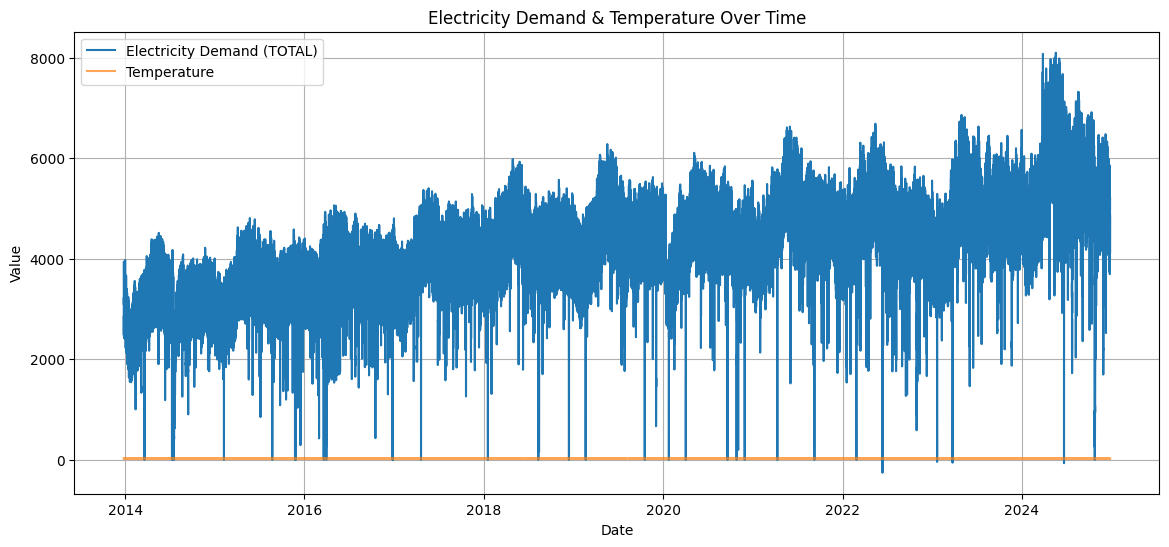

In [61]:
# Plot the new data to see if the inconsistencies were gone

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# File path
file_path = "Demand_with_Temperature.csv"
chunksize = 10_000  # Initial chunk size

# Load dataset with progress bar
chunks = []
with tqdm(total=total_rows, desc="Loading CSV", unit="rows") as pbar:
    for chunk in pd.read_csv(file_path, parse_dates=["DateTime"], index_col="DateTime", chunksize=chunksize):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)

# Plot Demand (TOTAL) and Temperature
plt.figure(figsize=(14,6))
plt.plot(df.index, df["TOTAL"], label="Electricity Demand (TOTAL)", color="tab:blue")
plt.plot(df.index, df["Temperature"], label="Temperature", color="tab:orange", alpha=0.7)
plt.title("Electricity Demand & Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [62]:
# Check dates that experienced power outage

import pandas as pd

# Load CSV
file_path = "Demand_with_Temperature.csv"
df = pd.read_csv(file_path)

# Ensure DateTime is datetime
df["DateTime"] = pd.to_datetime(df["DateTime"], format="mixed", errors="coerce")

# Find rows with negative TOTAL
neg_demands = df[df["TOTAL"] <= 0]

print(f"Number of rows with negative demand: {len(neg_demands)}")
if not neg_demands.empty:
    print(neg_demands[["DateTime", "TOTAL"]])


Number of rows with negative demand: 3336
                       DateTime  TOTAL
24265   2014-03-20 07:05:00.000    0.0
24266   2014-03-20 07:10:00.000    0.0
24267   2014-03-20 07:15:00.000    0.0
24268   2014-03-20 07:20:00.000    0.0
24269   2014-03-20 07:25:00.000    0.0
...                         ...    ...
1139258 2024-10-24 19:14:59.976    0.0
1139259 2024-10-24 19:19:59.976    0.0
1139260 2024-10-24 19:24:59.976    0.0
1139261 2024-10-24 19:29:59.976    0.0
1139262 2024-10-24 19:34:59.976    0.0

[3336 rows x 2 columns]


In [63]:
# Fix inconsistency in outage binary indicator

import pandas as pd

# Load CSV
file_path = "Demand_with_Temperature.csv"
df = pd.read_csv(file_path)

# Ensure DateTime is datetime
df["DateTime"] = pd.to_datetime(df["DateTime"], format="mixed", errors="coerce")

# Fix Outage based on TOTAL
df["Outage"] = (df["TOTAL"] <= 0).astype(int)

# Optional: check first few rows
print(df[["DateTime", "TOTAL", "Outage"]].head())

# Save updated CSV
df.to_csv("Demand_with_Temperature.csv", index=False)


             DateTime        TOTAL  Outage
0 2013-12-26 01:00:00  2850.352704       0
1 2013-12-26 01:05:00  2740.011311       0
2 2013-12-26 01:10:00  2740.011311       0
3 2013-12-26 01:15:00  2740.011311       0
4 2013-12-26 01:20:00  2740.011311       0


### Check correlation

Check the correlation between "demand" (TOTAL) and "temperature"

                TOTAL    Outage        Monday       Tuesday     Wednesday  \
TOTAL        1.000000 -0.224155  1.411487e-02 -1.083789e-02 -5.116204e-03   
Outage      -0.224155  1.000000 -1.863528e-02 -1.255510e-02 -2.053242e-03   
Monday       0.014115 -0.018635  1.000000e+00 -1.666681e-01 -1.666687e-01   
Tuesday     -0.010838 -0.012555 -1.666681e-01  1.000000e+00 -1.666681e-01   
Wednesday   -0.005116 -0.002053 -1.666687e-01 -1.666681e-01  1.000000e+00   
Thursday    -0.008769  0.019874 -1.666616e-01 -1.666610e-01 -1.666616e-01   
Friday       0.015463 -0.007673 -1.666687e-01 -1.666681e-01 -1.666687e-01   
Saturday     0.012263  0.018075 -1.666693e-01 -1.666687e-01 -1.666693e-01   
Sunday      -0.017117  0.002967 -1.666687e-01 -1.666681e-01 -1.666687e-01   
Holiday      0.068160 -0.000876 -4.698865e-03  1.024931e-02 -1.067787e-02   
ECQ          0.038467 -0.003292 -1.671895e-03 -1.671748e-03 -1.671895e-03   
GCQ          0.150008  0.001201  1.836367e-03 -3.007901e-04 -3.091754e-04   

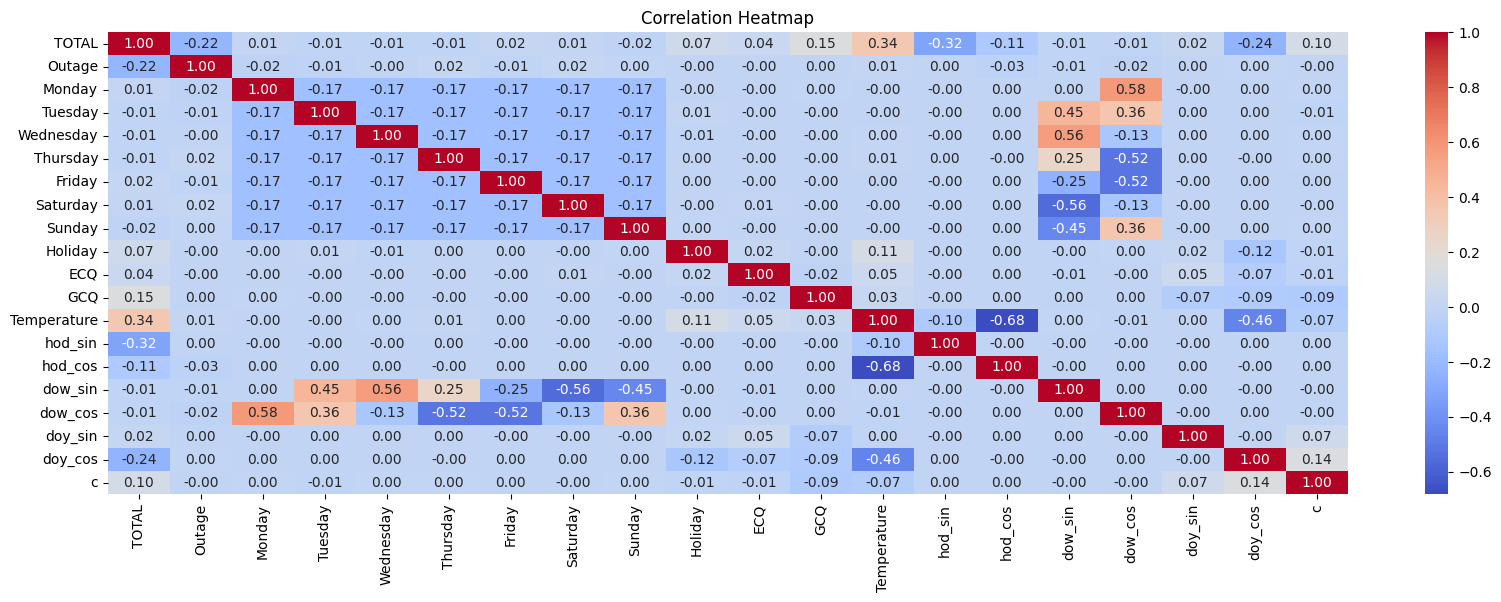

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("tmp/modified_outage.csv", parse_dates=["DateTime"])

# Compute correlations only for numeric columns
corr = df.corr(numeric_only=True)

# Print the correlation matrix
print(corr)

# Plot heatmap for easier visualization
plt.figure(figsize=(20,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


### Check inconsistency with the DateTime

In [65]:
# Check invalid rows
import pandas as pd

# Load raw CSV (no parsing yet)
df_raw = pd.read_csv("Demand_with_Temperature.csv")

# Try to parse DateTime
df_raw["ParsedDateTime"] = pd.to_datetime(df_raw["DateTime"], errors="coerce")

# Find problematic rows (where parsing failed → NaT)
invalid_rows = df_raw[df_raw["ParsedDateTime"].isna()]

# Show summary
print(f"Total invalid DateTime rows: {len(invalid_rows)}")

# Display first few invalid rows
print(invalid_rows.head(20))

# Save them to a CSV for inspection
# invalid_rows.to_csv("Invalid_DateTime_Rows.csv", index=False)


Total invalid DateTime rows: 316046
                       DateTime        TOTAL  Outage  Monday  Tuesday  \
841126  2021-12-24 14:50:00.000  4792.022175       0       0        0   
841127  2021-12-24 14:55:00.000  4792.022175       0       0        0   
841128  2021-12-24 15:00:00.000  4741.859891       0       0        0   
841129  2021-12-24 15:05:00.000  4741.859891       0       0        0   
841130  2021-12-24 15:10:00.000  4741.859891       0       0        0   
841131  2021-12-24 15:15:00.000  4741.859891       0       0        0   
841132  2021-12-24 15:20:00.000  4741.859891       0       0        0   
841133  2021-12-24 15:25:00.000  4741.859891       0       0        0   
841134  2021-12-24 15:30:00.000  4741.859891       0       0        0   
841135  2021-12-24 15:35:00.000  4741.859891       0       0        0   
841136  2021-12-24 15:40:00.000  4741.859891       0       0        0   
841137  2021-12-24 15:45:00.000  4741.859891       0       0        0   
841138  2021-12

In [66]:
# Remove milliseconds

import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("Demand_with_Temperature.csv")

# --- Step 1: Clean the DateTime column as string ---
df["DateTime"] = df["DateTime"].astype(str).str.strip()

# Remove milliseconds if present (anything after ".")
df["DateTime"] = df["DateTime"].str.replace(r"\.\d+$", "", regex=True)

# Replace known invalids
df["DateTime"] = df["DateTime"].replace(["0000-00-00 00:00:00", "NaT", "nan", ""], np.nan)

# --- Step 2: Parse into datetime ---
df["DateTime"] = pd.to_datetime(df["DateTime"], errors="coerce", format="%Y-%m-%d %H:%M:%S")

# --- Step 3: Fill invalids ---
df["DateTime"] = df["DateTime"].fillna(method="ffill").fillna(method="bfill")

# --- Step 4: Verify if still broken ---
invalid_rows = df[df["DateTime"].isna()]
print(f"Remaining invalid DateTime rows: {len(invalid_rows)}")

# --- Step 5: Save cleaned file ---
df.to_csv("Demand_with_Temperature.csv", index=False)
print("Done")


/tmp/ipykernel_2991806/2250380313.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["DateTime"] = df["DateTime"].fillna(method="ffill").fillna(method="bfill")


Remaining invalid DateTime rows: 0
Done


In [67]:
# Fix 5 min interval
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("Demand_with_Temperature.csv")

# --- Step 1: Parse DateTime safely ---
df["DateTime"] = pd.to_datetime(df["DateTime"], errors="coerce")

# --- Step 2: Fix invalids (forward fill then backfill) ---
df["DateTime"] = df["DateTime"].fillna(method="ffill").fillna(method="bfill")

# --- Step 3: Snap to nearest 5-minute interval ---
df["DateTime"] = df["DateTime"].dt.round("5min")

# --- Step 4: Ensure no duplicates (optional, if rounding caused collisions) ---
df = df.drop_duplicates(subset=["DateTime"], keep="first")

# --- Step 5: Save back ---
df.to_csv("Demand_with_Temperature.csv", index=False)

print("DateTime normalized to 5-minute intervals.csv")


/tmp/ipykernel_2991806/3168316187.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["DateTime"] = df["DateTime"].fillna(method="ffill").fillna(method="bfill")


DateTime normalized to 5-minute intervals.csv


Loading CSV: 100%|██████████| 1157172/1157172 [00:01<00:00, 891586.49rows/s]


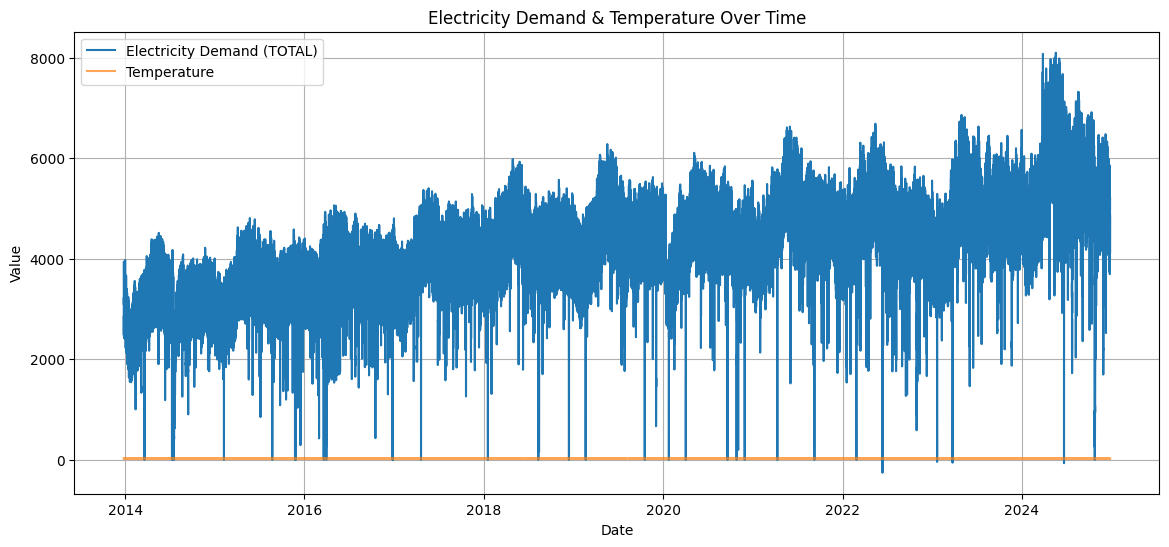

In [71]:
# Plot the new data to see if the noises were fixed using kalman filter

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# File path
file_path = "Demand_with_Temperature.csv"
chunksize = 10_000  # Initial chunk size

# Load dataset with progress bar
chunks = []
with tqdm(total=total_rows, desc="Loading CSV", unit="rows") as pbar:
    for chunk in pd.read_csv(file_path, parse_dates=["DateTime"], index_col="DateTime", chunksize=chunksize):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)

# Plot Demand (TOTAL) and Temperature
plt.figure(figsize=(14,6))
plt.plot(df.index, df["TOTAL"], label="Electricity Demand (TOTAL)", color="tab:blue")
plt.plot(df.index, df["Temperature"], label="Temperature", color="tab:orange", alpha=0.7)
plt.title("Electricity Demand & Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


### Use Kalman Filter for removing outage the dataset

Warning: (dont run)

In [ ]:
Don't run

In [69]:
# Analyze outages where TOTAL <= 0 (power outages / invalid readings)

import pandas as pd
import numpy as np

# --- Config ---
DATA_FILE = "Demand_with_Temperature.csv"  # change if you want a different variant
EXPORT_RUNS_CSV = True
RUNS_OUTPUT = "Outage_Runs.csv"
EXPECTED_STEP = pd.Timedelta(minutes=5)  # used for sanity checking cadence

# --- Load Data ---
df_o = pd.read_csv(DATA_FILE, parse_dates=["DateTime"])
if df_o.empty:
    raise ValueError("Loaded dataframe is empty – check file path.")

df_o = df_o.sort_values("DateTime").reset_index(drop=True)
df_o.set_index("DateTime", inplace=True)

if "TOTAL" not in df_o.columns:
    raise KeyError("Column 'TOTAL' not found in the dataset.")

# --- Basic cadence sanity ---
if len(df_o.index) > 2:
    diffs = (df_o.index[1:] - df_o.index[:-1])
    modal = diffs.to_series().mode()
    dominant = modal.iloc[0] if not modal.empty else None
    if dominant != EXPECTED_STEP:
        print(f"[WARN] Dominant step={dominant}, expected={EXPECTED_STEP}. Outage duration calculations assume 5-minute steps.")

# --- Outage mask (<=0) ---
out_mask = df_o["TOTAL"] <= 0
num_out_rows = int(out_mask.sum())
print(f"Total outage rows (TOTAL <= 0): {num_out_rows}")

if num_out_rows == 0:
    print("No outages detected.")
else:
    # --- Identify contiguous outage runs ---
    # Start of a run where current is True and previous is False
    run_starts = (out_mask & ~out_mask.shift(1, fill_value=False))
    # Cumulative sum of starts gives a run id (0 where mask False)
    run_id = run_starts.cumsum() * out_mask.astype(int)

    outage_rows = df_o.loc[out_mask, ["TOTAL"]].copy()
    outage_rows["run_id"] = run_id[out_mask]

    # Group to summarize each run
    runs = (
        outage_rows
        .groupby("run_id", sort=True)
        .apply(lambda g: pd.Series({
            "start": g.index[0],
            "end": g.index[-1],
            "steps": len(g)
        }))
        .reset_index(drop=True)
    )
    runs["duration_minutes"] = runs["steps"] * (EXPECTED_STEP / pd.Timedelta(minutes=1))
    runs["duration_hours"] = runs["duration_minutes"] / 60.0

    total_minutes = runs["duration_minutes"].sum()
    longest_minutes = runs["duration_minutes"].max()
    longest_run = runs.loc[runs["duration_minutes"].idxmax()] if not runs.empty else None

    print("\nOutage Summary:")
    print(f"  Number of distinct outage episodes: {len(runs)}")
    print(f"  Total outage minutes: {total_minutes:.0f} (~{total_minutes/60:.2f} hours)")
    print(f"  Longest outage: {longest_minutes:.0f} minutes (~{longest_minutes/60:.2f} hours)")
    if longest_run is not None:
        print(f"    Longest run start: {longest_run['start']}")
        print(f"    Longest run end  : {longest_run['end']}")

    # Display first few runs
    print("\nFirst 5 outage episodes:")
    print(runs.head())

    if EXPORT_RUNS_CSV:
        runs.to_csv(RUNS_OUTPUT, index=False)
        print(f"\nSaved outage episodes to {RUNS_OUTPUT}")

    # Optional: create a concise per-timestamp result table (commented out)
    # outage_rows.to_csv("Outage_Rows_Detail.csv")

# Quick integrity check: ensure mask aligns
# (All rows in outage_rows should have TOTAL <= 0 if outages exist)
if num_out_rows > 0 and not (df_o.loc[out_mask, "TOTAL"] <= 0).all():
    print("[WARN] Some rows flagged as outage do not have TOTAL <= 0 – investigate.")
else:
    print("Integrity check passed.")


Total outage rows (TOTAL <= 0): 3336

Outage Summary:
  Number of distinct outage episodes: 31
  Total outage minutes: 16680 (~278.00 hours)
  Longest outage: 3660 minutes (~61.00 hours)
    Longest run start: 2014-07-16 05:00:00
    Longest run end  : 2014-07-18 17:55:00

First 5 outage episodes:
                start                 end  steps  duration_minutes  \
0 2014-03-20 07:05:00 2014-03-20 18:00:00    132             660.0   
1 2014-07-10 10:00:00 2014-07-10 16:55:00     84             420.0   
2 2014-07-16 05:00:00 2014-07-18 17:55:00    732            3660.0   
3 2015-02-07 02:05:00 2015-02-07 10:00:00     96             480.0   
4 2015-08-23 01:00:00 2015-08-23 07:55:00     84             420.0   

   duration_hours  
0            11.0  
1             7.0  
2            61.0  
3             8.0  
4             7.0  

Saved outage episodes to Outage_Runs.csv
Integrity check passed.


/tmp/ipykernel_2991806/1258703471.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [70]:
# use kalman to fix outages
# BUG: There are inconsistencies that isn't solved using  "x <= 0"

import pandas as pd
import numpy as np
from pykalman import KalmanFilter

# --- Load data ---
df = pd.read_csv(
    "Demand_with_Temperature.csv",
    parse_dates=["DateTime"],
    index_col="DateTime"
)

# --- Step 1: Mark outages (TOTAL <= 0) as missing ---
df.loc[df["TOTAL"] <= 0, "TOTAL"] = np.nan

# --- Step 2: Temporary fill for NaNs (linear interpolation) ---
# This just helps Kalman start, Kalman will refine it
observed = df["TOTAL"].interpolate(method="time").fillna(method="bfill").fillna(method="ffill")

# --- Step 3: Initialize Kalman Filter ---
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=observed.iloc[0],
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.01
)

# --- Step 4: Fit & smooth ---
smoothed_state_means, _ = kf.em(observed.values, n_iter=5).smooth(observed.values)

# --- Step 5: Replace TOTAL with smoothed values ---
df["TOTAL"] = smoothed_state_means

# --- Step 6: Save cleaned dataset ---
df.to_csv("Demand_with_Temperature_Kalman.csv")

print("Done")

/tmp/ipykernel_2991806/928810277.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  observed = df["TOTAL"].interpolate(method="time").fillna(method="bfill").fillna(method="ffill")


KeyboardInterrupt: 

Loading CSV: 100%|██████████| 1157172/1157172 [00:01<00:00, 843470.70rows/s]


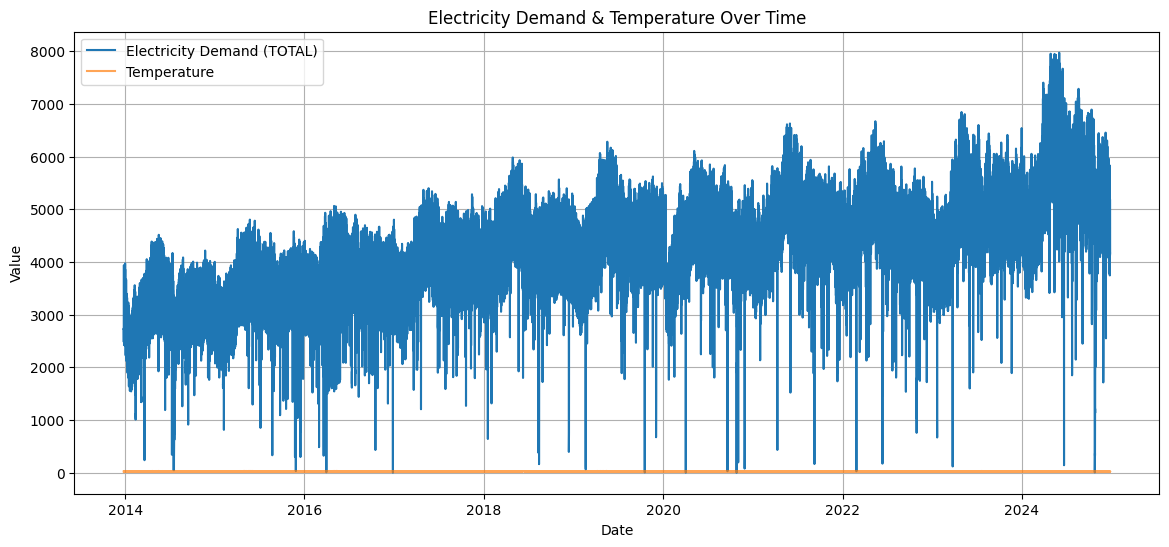

In [ ]:
# Plot the new data to see if the noises were fixed using kalman filter

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# File path
file_path = "Demand_with_Temperature_Kalman.csv"
chunksize = 10_000  # Initial chunk size

# Load dataset with progress bar
chunks = []
with tqdm(total=total_rows, desc="Loading CSV", unit="rows") as pbar:
    for chunk in pd.read_csv(file_path, parse_dates=["DateTime"], index_col="DateTime", chunksize=chunksize):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)

# Plot Demand (TOTAL) and Temperature
plt.figure(figsize=(14,6))
plt.plot(df.index, df["TOTAL"], label="Electricity Demand (TOTAL)", color="tab:blue")
plt.plot(df.index, df["Temperature"], label="Temperature", color="tab:orange", alpha=0.7)
plt.title("Electricity Demand & Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


### Sudden drop but didn't meet <=0 or outage

Warning: (Don't run)

In [ ]:
Don't run

In [ ]:
# Detect sudden drops (>=20%) between consecutive 5‑minute readings (non-outage focus)
# Mirrors the outage analysis structure but uses a relative drop mask instead of TOTAL <= 0.

import pandas as pd
import numpy as np

# --- Config ---
DATA_FILE = "Demand_with_Temperature.csv"  # input dataset
EXPECTED_STEP = pd.Timedelta(minutes=5)     # assumed cadence
DROP_THRESHOLD = 0.20                       # 20% drop
MIN_BASE_VALUE = 1e-6                       # avoid division by ~0
EXPORT_RUNS_CSV = True
RUNS_OUTPUT = "SuddenDrop_Runs.csv"
TOP_N_PRINT = 5

# --- Load Data ---
df_o = pd.read_csv(DATA_FILE, parse_dates=["DateTime"])
if df_o.empty:
    raise ValueError("Loaded dataframe is empty – check file path.")

df_o = df_o.sort_values("DateTime").reset_index(drop=True)
df_o.set_index("DateTime", inplace=True)

if "TOTAL" not in df_o.columns:
    raise KeyError("Column 'TOTAL' not found in the dataset.")

# --- Basic cadence sanity ---
if len(df_o.index) > 2:
    diffs = (df_o.index[1:] - df_o.index[:-1])
    modal = diffs.to_series().mode()
    dominant = modal.iloc[0] if not modal.empty else None
    if dominant != EXPECTED_STEP:
        print(f"[WARN] Dominant step={dominant}, expected={EXPECTED_STEP}. Duration calculations assume 5-minute steps.")

# --- Sudden drop mask ---
total_series = df_o["TOTAL"].astype(float)
prev = total_series.shift(1)
with np.errstate(divide='ignore', invalid='ignore'):
    rel_drop = (prev - total_series) / prev  # positive when current < prev
    rel_drop = rel_drop.where(prev.abs() > MIN_BASE_VALUE, other=0.0)

sudden_mask = (
    prev.notna() & total_series.notna() &  # need valid consecutive points
    (rel_drop >= DROP_THRESHOLD) &         # meets relative threshold
    (prev > total_series)                  # ensure it's actually a drop
)

num_sudden_rows = int(sudden_mask.sum())
print(f"Total sudden-drop rows (>= {DROP_THRESHOLD*100:.1f}%): {num_sudden_rows}")

if num_sudden_rows == 0:
    print("No sudden drops detected at this threshold.")
else:
    # --- Identify contiguous sudden-drop runs ---
    run_starts = (sudden_mask & ~sudden_mask.shift(1, fill_value=False))
    run_id = run_starts.cumsum() * sudden_mask.astype(int)

    sudden_rows = df_o.loc[sudden_mask, ["TOTAL"]].copy()
    sudden_rows["run_id"] = run_id[sudden_mask]
    sudden_rows["rel_drop"] = rel_drop[sudden_mask]
    sudden_rows["abs_drop"] = (prev - total_series)[sudden_mask]

    # Group to summarize each run
    runs = (
        sudden_rows
        .groupby("run_id", sort=True)
        .apply(lambda g: pd.Series({
            "start": g.index[0],
            "end": g.index[-1],
            "steps": len(g),
            "max_rel_drop": g["rel_drop"].max(),
            "mean_rel_drop": g["rel_drop"].mean(),
            "max_abs_drop": g["abs_drop"].max()
        }))
        .reset_index(drop=True)
    )

    runs["duration_minutes"] = runs["steps"] * (EXPECTED_STEP / pd.Timedelta(minutes=1))
    runs["duration_hours"] = runs["duration_minutes"] / 60.0

    total_minutes = runs["duration_minutes"].sum()
    longest_minutes = runs["duration_minutes"].max()
    longest_run = runs.loc[runs["duration_minutes"].idxmax()] if not runs.empty else None

    print("\nSudden Drop Summary:")
    print(f"  Number of distinct sudden-drop episodes: {len(runs)}")
    print(f"  Total sudden-drop minutes: {total_minutes:.0f} (~{total_minutes/60:.2f} hours)")
    print(f"  Longest episode: {longest_minutes:.0f} minutes (~{longest_minutes/60:.2f} hours)")
    if longest_run is not None:
        print(f"    Longest start: {longest_run['start']}")
        print(f"    Longest end  : {longest_run['end']}")

    print("\nFirst 5 sudden-drop episodes:")
    print(runs.head())

    # Top N individual drops
    topN = sudden_rows.sort_values("rel_drop", ascending=False).head(TOP_N_PRINT)
    print(f"\nTop {TOP_N_PRINT} largest individual sudden drops (timestamp, rel_drop%, abs_drop):")
    for ts, row in topN.iterrows():
        print(f"  {ts}: {row['rel_drop']*100:.1f}% (abs {row['abs_drop']:.2f})")

    if EXPORT_RUNS_CSV:
        runs.to_csv(RUNS_OUTPUT, index=False)
        print(f"\nSaved sudden-drop episodes to {RUNS_OUTPUT}")

print("\nDone.")

Total sudden-drop rows (>= 20.0%): 544

Sudden Drop Summary:
  Number of distinct sudden-drop episodes: 514
  Total sudden-drop minutes: 2720 (~45.33 hours)
  Longest episode: 15 minutes (~0.25 hours)
    Longest start: 2024-10-23 15:15:00
    Longest end  : 2024-10-23 15:25:00

First 5 sudden-drop episodes:
                start                 end  steps  max_rel_drop  mean_rel_drop  \
0 2014-02-12 08:05:00 2014-02-12 08:05:00      1      0.474736       0.474736   
1 2014-02-13 07:05:00 2014-02-13 07:05:00      1      0.302965       0.302965   
2 2014-03-07 08:05:00 2014-03-07 08:05:00      1      0.414468       0.414468   
3 2014-03-20 06:05:00 2014-03-20 06:05:00      1      0.899665       0.899665   
4 2014-03-20 07:05:00 2014-03-20 07:05:00      1      1.000000       1.000000   

   max_abs_drop  duration_minutes  duration_hours  
0    907.422304               5.0        0.083333  
1    677.100196               5.0        0.083333  
2    971.941016               5.0        0.0833

/tmp/ipykernel_2991806/1050888741.py:67: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


/tmp/ipykernel_2991806/776358046.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="bfill")
/tmp/ipykernel_2991806/776358046.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill")


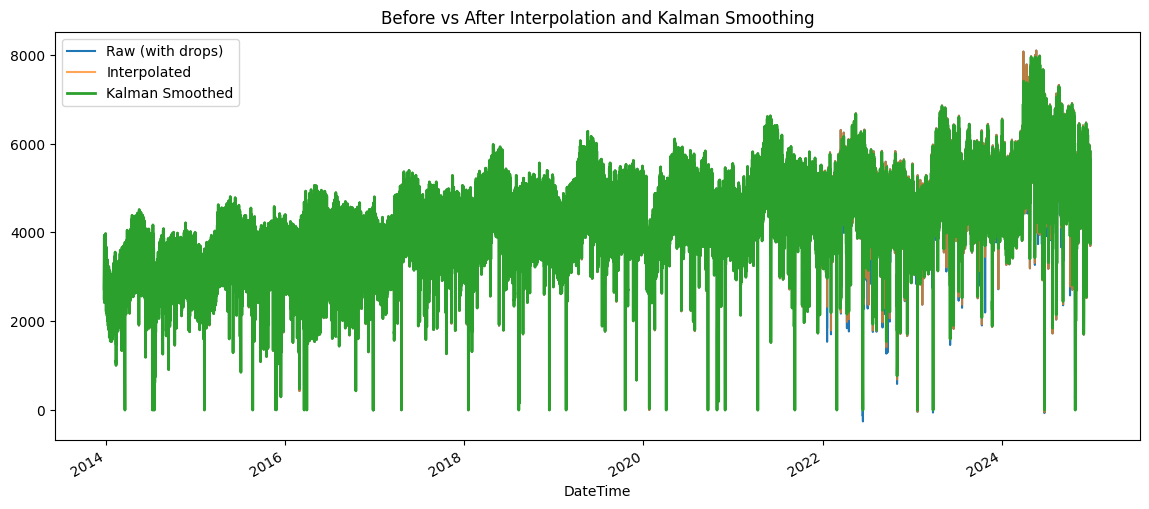

Done


In [ ]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

# --- Load data ---
df = pd.read_csv(
    "Demand_with_Temperature.csv",
    parse_dates=["DateTime"],
    index_col="DateTime"
)

# --- Step 1: Mark outages (≥20% drop vs. previous value) as missing ---
# Compute % change
pct_change = df["TOTAL"].pct_change()

# If the drop is 20% or more (i.e. <= -0.2), mark as NaN
df.loc[pct_change <= -0.1, "TOTAL"] = np.nan

# --- Step 2: Temporary fill for NaNs (linear interpolation) ---
observed = df["TOTAL"].interpolate(method="time").fillna(method="bfill").fillna(method="ffill")

# --- Step 3: Initialize Kalman Filter ---
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=observed.iloc[0],
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.01
)

# --- Step 4: Fit & smooth ---
smoothed_state_means, _ = kf.em(observed.values, n_iter=5).smooth(observed.values)

# --- Step 5: Replace TOTAL with smoothed values ---
df["TOTAL"] = smoothed_state_means

# --- Step 6: Save cleaned dataset ---
df.to_csv("Demand_with_Temperature_Kalman2.csv")

print("Done")


In [ ]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# --- Load sample data ---
df = pd.read_csv(
    "Demand_with_Temperature.csv",
    parse_dates=["DateTime"],
    index_col="DateTime"
)

# --- Step 1: Detect outliers in TOTAL (z-score > 3) ---
z_scores = (df["TOTAL"] - df["TOTAL"].mean()) / df["TOTAL"].std()
outliers = np.abs(z_scores) > 3

# Mark outliers as NaN
df.loc[outliers, "TOTAL"] = np.nan

# --- Step 2: Kalman Filter setup ---
kf = KalmanFilter(
    transition_matrices=[1],       # simple random walk model
    observation_matrices=[1],
    initial_state_mean=df["TOTAL"].mean(),
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.01
)

# --- Step 3: Apply Kalman smoother (handles NaN automatically) ---
state_means, _ = kf.smooth(df["TOTAL"].values)
state_means = state_means.flatten()  # <-- flatten from (n,1) → (n,)

# Replace NaN and outliers with smoothed estimates
df["TOTAL_KF"] = df["TOTAL"].copy()
df["TOTAL_KF"].fillna(pd.Series(state_means, index=df.index), inplace=True)

# --- Step 4: Plot to visualize ---
# plt.figure(figsize=(12,6))
# plt.plot(df.index, state_means, label="Kalman Smoothed", color="red")
# plt.plot(df.index, df["TOTAL_KF"], label="TOTAL (fixed)", alpha=0.7)
# plt.plot(df.index, df["TOTAL"], "k.", label="TOTAL (with NaNs/outliers)", alpha=0.5)
# plt.legend()
# plt.title("Outlier Fix with Kalman Filter")
# plt.show()

# Save results
df.to_csv("Demand_with_Temperature_Kalman2.csv")


/tmp/ipykernel_2991806/2732983188.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TOTAL_KF"].fillna(pd.Series(state_means, index=df.index), inplace=True)


Loading CSV: 100%|██████████| 1157172/1157172 [00:03<00:00, 297895.11rows/s]



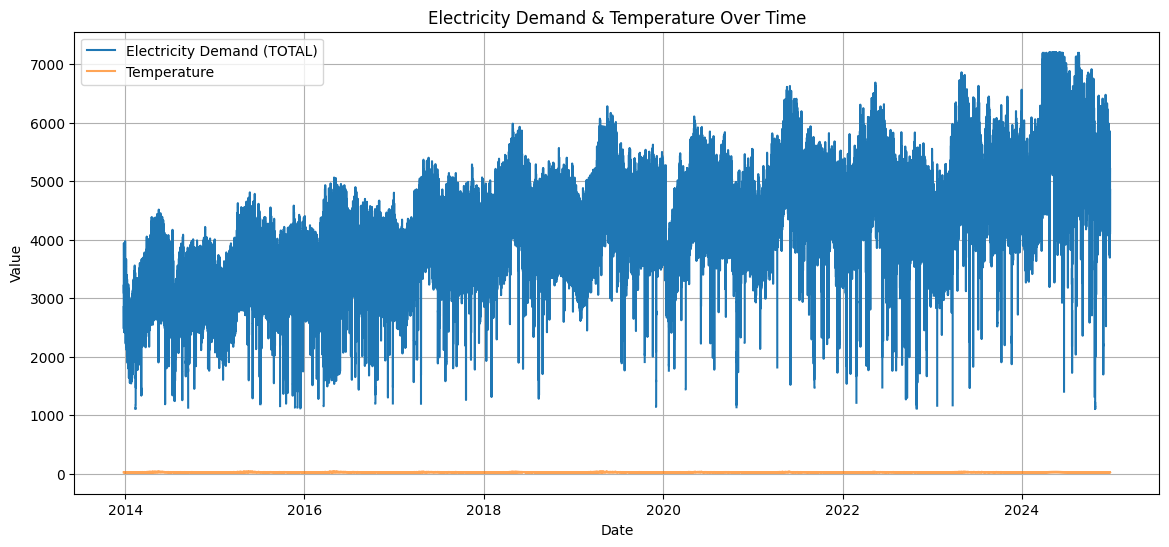

In [ ]:
# Plot the new data to see if the noises were fixed using kalman filter

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# File path
file_path = "Demand_with_Temperature_Kalman2.csv"
chunksize = 50_000  # Initial chunk size

# Load dataset with progress bar
chunks = []
with tqdm(total=total_rows, desc="Loading CSV", unit="rows") as pbar:
    for chunk in pd.read_csv(file_path, parse_dates=["DateTime"], index_col="DateTime", chunksize=chunksize):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)

# Plot Demand (TOTAL) and Temperature
plt.figure(figsize=(14,6))
plt.plot(df.index, df["TOTAL"], label="Electricity Demand (TOTAL)", color="tab:blue")
plt.plot(df.index, df["Temperature"], label="Temperature", color="tab:orange", alpha=0.7)
plt.title("Electricity Demand & Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


### Fix binary indicator for Outage

In [78]:
# Analyze outages 
# This code was made to just help locate the outages in the dataset
# We still have to manually check the outages if they are real or not

import pandas as pd
import numpy as np

# --- Config ---
DATA_FILE = "Demand_with_Temperature.csv"  # change if you want a different variant
EXPORT_RUNS_CSV = True
RUNS_OUTPUT = "tmp/sudden_drops_50%.csv"
EXPECTED_STEP = pd.Timedelta(minutes=5)  # used for sanity checking cadence
DROP_THRESHOLD = 0.50  # 20% drop compared to previous value = outage

# --- Load Data ---
df_o = pd.read_csv(DATA_FILE, parse_dates=["DateTime"])
if df_o.empty:
    raise ValueError("Loaded dataframe is empty – check file path.")

df_o = df_o.sort_values("DateTime").reset_index(drop=True)
df_o.set_index("DateTime", inplace=True)

if "TOTAL" not in df_o.columns:
    raise KeyError("Column 'TOTAL' not found in the dataset.")

# --- Basic cadence sanity ---
if len(df_o.index) > 2:
    diffs = (df_o.index[1:] - df_o.index[:-1])
    modal = diffs.to_series().mode()
    dominant = modal.iloc[0] if not modal.empty else None
    if dominant != EXPECTED_STEP:
        print(f"[WARN] Dominant step={dominant}, expected={EXPECTED_STEP}. Outage duration calculations assume 5-minute steps.")

# --- Outage mask (<=0 OR sudden drop) ---
# 1. Flag rows where TOTAL <= 0
out_mask_zero = df_o["TOTAL"] <= 0

# 2. Flag rows where current < (1 - DROP_THRESHOLD) * previous
# shift(1) gives the previous row's TOTAL value
drop_mask = df_o["TOTAL"] < (1 - DROP_THRESHOLD) * df_o["TOTAL"].shift(1)

# 3. Combine both conditions
out_mask = out_mask_zero | drop_mask

num_out_rows = int(out_mask.sum())
print(f"Total outage rows (<=0 or sudden drop >={DROP_THRESHOLD*100:.0f}%): {num_out_rows}")

if num_out_rows == 0:
    print("No outages detected.")
else:
    # --- Identify contiguous outage runs ---
    run_starts = (out_mask & ~out_mask.shift(1, fill_value=False))
    run_id = run_starts.cumsum() * out_mask.astype(int)

    outage_rows = df_o.loc[out_mask, ["TOTAL"]].copy()
    outage_rows["run_id"] = run_id[out_mask]

    runs = (
        outage_rows
        .groupby("run_id", sort=True)
        .apply(lambda g: pd.Series({
            "start": g.index[0],
            "end": g.index[-1],
            "steps": len(g)
        }))
        .reset_index(drop=True)
    )
    runs["duration_minutes"] = runs["steps"] * (EXPECTED_STEP / pd.Timedelta(minutes=1))
    runs["duration_hours"] = runs["duration_minutes"] / 60.0

    total_minutes = runs["duration_minutes"].sum()
    longest_minutes = runs["duration_minutes"].max()
    longest_run = runs.loc[runs["duration_minutes"].idxmax()] if not runs.empty else None

    print("\nOutage Summary:")
    print(f"  Number of distinct outage episodes: {len(runs)}")
    print(f"  Total outage minutes: {total_minutes:.0f} (~{total_minutes/60:.2f} hours)")
    print(f"  Longest outage: {longest_minutes:.0f} minutes (~{longest_minutes/60:.2f} hours)")
    if longest_run is not None:
        print(f"    Longest run start: {longest_run['start']}")
        print(f"    Longest run end  : {longest_run['end']}")

    print("\nFirst 5 outage episodes:")
    print(runs.head())

    if EXPORT_RUNS_CSV:
        runs.to_csv(RUNS_OUTPUT, index=False)
        print(f"\nSaved outage episodes to {RUNS_OUTPUT}")

# Quick integrity check
if num_out_rows > 0 and not (df_o.loc[out_mask, "TOTAL"] <= 0).all():
    print("[INFO] Some rows flagged due to sudden drop, not because TOTAL <= 0.")
else:
    print("Integrity check passed.")


Total outage rows (<=0 or sudden drop >=50%): 3406

Outage Summary:
  Number of distinct outage episodes: 98
  Total outage minutes: 17030 (~283.83 hours)
  Longest outage: 3660 minutes (~61.00 hours)
    Longest run start: 2014-07-16 05:00:00
    Longest run end  : 2014-07-18 17:55:00

First 5 outage episodes:
                start                 end  steps  duration_minutes  \
0 2014-03-20 06:05:00 2014-03-20 06:05:00      1               5.0   
1 2014-03-20 07:05:00 2014-03-20 18:00:00    132             660.0   
2 2014-07-10 09:00:00 2014-07-10 09:00:00      1               5.0   
3 2014-07-10 10:00:00 2014-07-10 16:55:00     84             420.0   
4 2014-07-16 01:00:00 2014-07-16 01:00:00      1               5.0   

   duration_hours  
0        0.083333  
1       11.000000  
2        0.083333  
3        7.000000  
4        0.083333  

Saved outage episodes to tmp/sudden_drops_50%.csv
[INFO] Some rows flagged due to sudden drop, not because TOTAL <= 0.


/tmp/ipykernel_2991806/2399463860.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


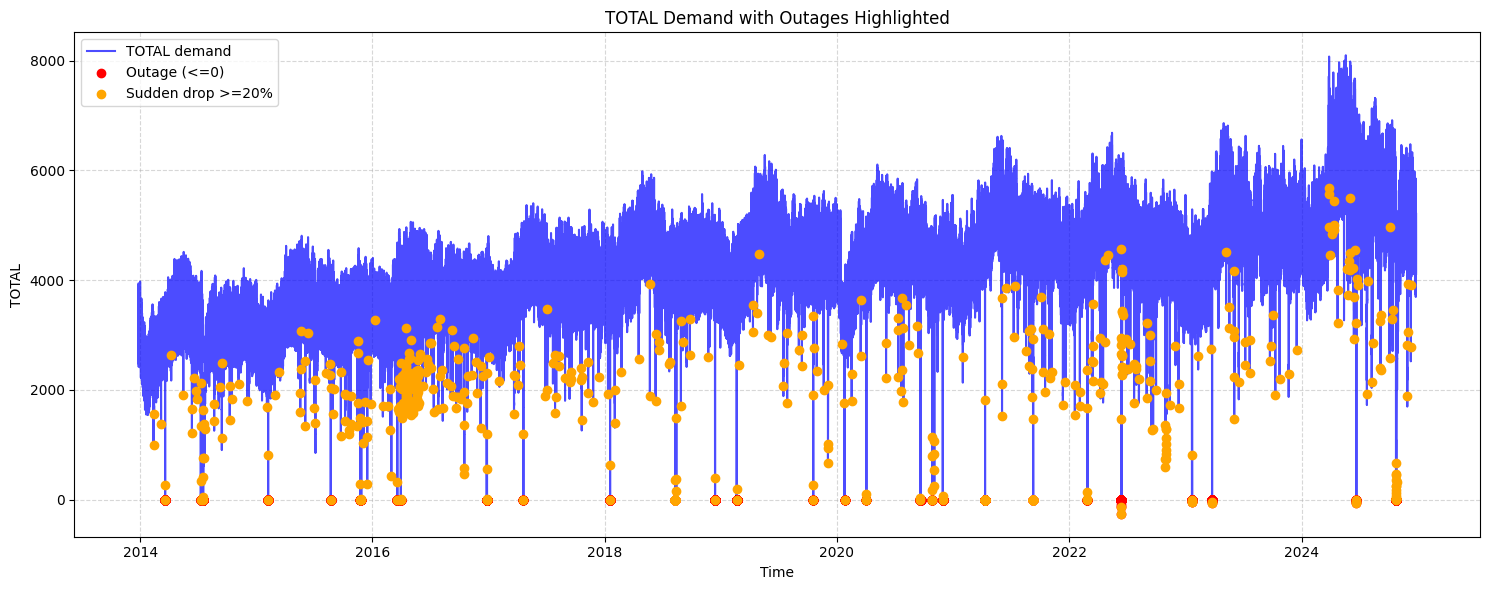

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
DATA_FILE = "Demand_with_Temperature.csv"
DROP_THRESHOLD = 0.20  # 20% drop considered outage

# --- Load data ---
df = pd.read_csv(DATA_FILE, parse_dates=["DateTime"])
df = df.sort_values("DateTime").reset_index(drop=True)
df.set_index("DateTime", inplace=True)

# --- Define outage masks ---
# 1. Outages where TOTAL <= 0
mask_zero = df["TOTAL"] <= 0

# 2. Outages where sudden drop compared to previous is >= threshold
mask_drop = df["TOTAL"] < (1 - DROP_THRESHOLD) * df["TOTAL"].shift(1)

# Combine
mask_outage = mask_zero | mask_drop

# --- Plot ---
plt.figure(figsize=(15, 6))

# Plot full series
plt.plot(df.index, df["TOTAL"], label="TOTAL demand", color="blue", alpha=0.7)

# Highlight <=0 outages
plt.scatter(df.index[mask_zero], df["TOTAL"][mask_zero],
            color="red", label="Outage (<=0)", zorder=5)

# Highlight sudden drops
plt.scatter(df.index[mask_drop], df["TOTAL"][mask_drop],
            color="orange", label=f"Sudden drop >={DROP_THRESHOLD*100:.0f}%", zorder=5)

plt.title("TOTAL Demand with Outages Highlighted")
plt.xlabel("Time")
plt.ylabel("TOTAL")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# New Segment

### Fix roughness of the data  
There are roughness of the data from **_2013-12-26 01:00:00_** to **_2021-12-25 23:55:00_**  
because its original nature was in **HOURLY** format,  
it was just then converted to 5 minutes format, duplicating the original one from its hourly value

In [5]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

# ---------------- CONFIG ----------------
DATA_FILE = "Demand_with_Temperature.csv"
OUTAGES_FILE = "tmp/Outage_Runs.csv"
EXPORT_FILE = "Demand_smoothed_kalman.csv"

START_HOURLY = pd.to_datetime("2013-12-26 01:00:00")
END_HOURLY   = pd.to_datetime("2021-12-25 23:55:00")

MAX_ANCHOR_GAP_HOURS = 6  # safety: skip smoothing when anchors too far apart

KEEP_COLS = [
    "DateTime","TOTAL","Outage",
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday",
    "Holiday","ECQ","GCQ",
    "ALERT LEVEL 1","ALERT LEVEL 2","ALERT LEVEL 3",
    "Temperature"
]

# ---------------- LOAD MAIN DATA ----------------
df = pd.read_csv(DATA_FILE, parse_dates=["DateTime"])
if df.empty:
    raise ValueError("Main data file is empty. Check path.")

df = df.sort_values("DateTime").reset_index(drop=True)
df.set_index("DateTime", inplace=True)

if "TOTAL" not in df.columns:
    raise KeyError("Column 'TOTAL' not found in dataset.")

# Keep original for reference
df["TOTAL_ORIG"] = df["TOTAL"].astype(float)

# ---------------- LOAD OUTAGES ----------------
outages = pd.read_csv(OUTAGES_FILE, parse_dates=["start","end"])
df["in_outage"] = False
for _, r in outages.iterrows():
    df.loc[r["start"]:r["end"], "in_outage"] = True

# ---------------- FIND ANCHORS ----------------
all_anchors = df.index[(df.index.minute == 0) & (df.index.second == 0)]
anchors = all_anchors[(all_anchors >= START_HOURLY) & (all_anchors <= END_HOURLY)]
anchors = anchors[~df.loc[anchors, "in_outage"]]
anchors = anchors.sort_values()

anchors_list = anchors.values
if len(anchors_list) < 2:
    print("Not enough anchors to smooth. Exiting.")
    df_out = df.reset_index()[KEEP_COLS]
    df_out.to_csv(EXPORT_FILE, index=False)
    raise SystemExit

# ---------------- KALMAN SMOOTHING ----------------
n_pairs = 0
n_smoothed = 0
n_skipped = 0

for i in range(len(anchors_list) - 1):
    t0 = pd.to_datetime(anchors_list[i])
    t1 = pd.to_datetime(anchors_list[i + 1])

    if t1 <= t0:
        continue

    if not (START_HOURLY <= t0 <= END_HOURLY and START_HOURLY <= t1 <= END_HOURLY):
        continue

    gap_hours = (t1 - t0) / pd.Timedelta(hours=1)
    if gap_hours > MAX_ANCHOR_GAP_HOURS:
        n_skipped += 1
        continue

    block = df.loc[t0:t1]

    if block["in_outage"].any():
        # restrict block to last point before outage
        clean_block = block[~block["in_outage"]]
        if len(clean_block) < 2:
            n_skipped += 1
            continue
        t1 = clean_block.index[-1]
        block = df.loc[t0:t1]

    if len(block) <= 2:
        continue

    values = block["TOTAL_ORIG"].values.astype(float)

    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=values[0],
        observation_covariance=1,
        transition_covariance=0.01
    )
    smoothed, _ = kf.smooth(values)

    # Preserve endpoints exactly
    smoothed[0] = values[0]
    smoothed[-1] = values[-1]

    df.loc[block.index, "TOTAL"] = smoothed

    n_pairs += 1
    n_smoothed += 1

print("Kalman smoothing complete.")
print(f"Anchor pairs processed : {n_pairs}")
print(f"Smoothed intervals     : {n_smoothed}")
print(f"Skipped intervals      : {n_skipped}")

# ---------------- EXPORT ----------------
df_out = df.reset_index()[KEEP_COLS]
df_out.to_csv(EXPORT_FILE, index=False)
print(f"Saved smoothed dataset to {EXPORT_FILE}")


Total anchors found: 69907
Skipping large gap: 2014-03-20 07:00:00 to 2014-03-20 19:00:00 (12.0 hours)
Skipping large gap: 2014-07-10 09:00:00 to 2014-07-10 17:00:00 (8.0 hours)
Skipping large gap: 2014-07-16 04:00:00 to 2014-07-18 18:00:00 (62.0 hours)
Skipping large gap: 2015-02-07 02:00:00 to 2015-02-07 11:00:00 (9.0 hours)
Skipping large gap: 2015-08-23 00:00:00 to 2015-08-23 08:00:00 (8.0 hours)
Skipping large gap: 2016-03-19 11:00:00 to 2016-03-19 18:00:00 (7.0 hours)
Block too small after outage truncation: 2016-03-30 12:00:00 to 2016-03-30 12:05:00
Skipping large gap: 2016-12-24 23:00:00 to 2016-12-26 00:00:00 (25.0 hours)
Block too small after outage truncation: 2016-12-26 12:00:00 to 2016-12-26 12:05:00
Skipping large gap: 2018-01-17 08:00:00 to 2018-01-17 19:00:00 (11.0 hours)
Skipping large gap: 2018-12-13 05:00:00 to 2018-12-13 21:00:00 (16.0 hours)
Skipping large gap: 2019-02-19 06:00:00 to 2019-02-20 00:00:00 (18.0 hours)
Block too small after outage truncation: 2020-01-

In [1]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

# ---------------- CONFIG ----------------
DATA_FILE = "Demand_with_Temperature.csv"
OUTAGES_FILE = "tmp/Outage_Runs.csv"
EXPORT_FILE = "Demand_smoothed_kalman.csv"

MAX_SMOOTH_POINTS = 72  # Maximum points to smooth in one continuous segment (6 hours * 12 points/hour)
MIN_SMOOTH_POINTS = 3   # Minimum points needed to apply smoothing

KEEP_COLS = [
    "DateTime","TOTAL","Outage",
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday",
    "Holiday","ECQ","GCQ",
    "ALERT LEVEL 1","ALERT LEVEL 2","ALERT LEVEL 3",
    "Temperature"
]

# ---------------- LOAD MAIN DATA ----------------
print("Loading main data...")
df = pd.read_csv(DATA_FILE, parse_dates=["DateTime"])
if df.empty:
    raise ValueError("Main data file is empty. Check path.")

df = df.sort_values("DateTime").reset_index(drop=True)
df.set_index("DateTime", inplace=True)

if "TOTAL" not in df.columns:
    raise KeyError("Column 'TOTAL' not found in dataset.")

# Keep original for reference
df["TOTAL_ORIG"] = df["TOTAL"].astype(float)
print(f"Loaded {len(df)} data points")

# ---------------- LOAD OUTAGES ----------------
print("Loading outages...")
outages = pd.read_csv(OUTAGES_FILE, parse_dates=["start","end"])
df["in_outage"] = False

for i, r in outages.iterrows():
    df.loc[r["start"]:r["end"], "in_outage"] = True
    
outage_count = df["in_outage"].sum()
print(f"Marked {outage_count} points as outages ({outage_count/len(df)*100:.2f}%)")

# ---------------- FIND CONTINUOUS NON-OUTAGE SEGMENTS ----------------
print("Finding continuous non-outage segments...")

# Create a group identifier for continuous non-outage segments
df['segment_id'] = (df['in_outage'] != df['in_outage'].shift()).cumsum()

# Get all non-outage segments
non_outage_segments = df[~df['in_outage']].groupby('segment_id')

segments_to_smooth = []
for seg_id, segment in non_outage_segments:
    if len(segment) >= MIN_SMOOTH_POINTS:
        segments_to_smooth.append({
            'id': seg_id,
            'start': segment.index[0], 
            'end': segment.index[-1],
            'length': len(segment)
        })

print(f"Found {len(segments_to_smooth)} non-outage segments to smooth")

# ---------------- KALMAN SMOOTHING ----------------
n_segments_processed = 0
n_segments_smoothed = 0
n_points_smoothed = 0

for seg_info in segments_to_smooth:
    seg_id = seg_info['id']
    start_time = seg_info['start']
    end_time = seg_info['end']
    seg_length = seg_info['length']
    
    print(f"\nProcessing segment {seg_id}: {start_time} to {end_time} ({seg_length} points)")
    
    # Get the segment data
    segment_data = df[df['segment_id'] == seg_id].copy()
    
    # If segment is too long, split it into smaller chunks
    if seg_length > MAX_SMOOTH_POINTS:
        print(f"  Segment too long ({seg_length} points), splitting into chunks...")
        
        # Split into overlapping chunks to maintain continuity
        chunk_size = MAX_SMOOTH_POINTS
        overlap = 5  # Small overlap to ensure continuity
        
        start_idx = 0
        chunk_num = 0
        
        while start_idx < seg_length:
            end_idx = min(start_idx + chunk_size, seg_length)
            chunk = segment_data.iloc[start_idx:end_idx]
            
            if len(chunk) >= MIN_SMOOTH_POINTS:
                print(f"    Chunk {chunk_num}: {chunk.index[0]} to {chunk.index[-1]} ({len(chunk)} points)")
                
                values = chunk["TOTAL_ORIG"].values.astype(float)
                
                try:
                    # Use adaptive covariance based on data variance
                    data_var = np.var(values)
                    obs_cov = max(data_var * 0.1, 0.1)  # At least 0.1
                    trans_cov = max(data_var * 0.001, 0.001)  # At least 0.001
                    
                    kf = KalmanFilter(
                        transition_matrices=[1],
                        observation_matrices=[1],
                        initial_state_mean=values[0],
                        observation_covariance=obs_cov,
                        transition_covariance=trans_cov
                    )
                    
                    smoothed, _ = kf.smooth(values)
                    
                    # Preserve original values at hourly timestamps
                    for j, timestamp in enumerate(chunk.index):
                        if timestamp.minute == 0 and timestamp.second == 0:
                            smoothed[j] = values[j]  # Keep original hourly value
                    
                    # For overlapping chunks, blend the overlapping region
                    if chunk_num > 0 and start_idx > 0:
                        # Keep the first few points from previous chunk
                        blend_size = min(overlap, len(smoothed)//2)
                        prev_values = df.loc[chunk.index[:blend_size], "TOTAL"].values
                        
                        # Weighted blend: more weight to previous chunk at start
                        for j in range(blend_size):
                            weight = (j + 1) / (blend_size + 1)  # 0 to 1
                            smoothed[j] = prev_values[j] * (1 - weight) + smoothed[j] * weight
                    
                    # Apply smoothed values
                    df.loc[chunk.index, "TOTAL"] = smoothed
                    n_points_smoothed += len(chunk)
                    
                    print(f"      Successfully smoothed {len(chunk)} points")
                    
                except Exception as e:
                    print(f"      Error smoothing chunk: {e}")
            
            # Move to next chunk with overlap
            start_idx = end_idx - overlap
            chunk_num += 1
            
            if end_idx >= seg_length:
                break
    
    else:
        # Segment is small enough to smooth all at once
        values = segment_data["TOTAL_ORIG"].values.astype(float)
        
        try:
            # Use adaptive covariance
            data_var = np.var(values)
            obs_cov = max(data_var * 0.1, 0.1)
            trans_cov = max(data_var * 0.001, 0.001)
            
            kf = KalmanFilter(
                transition_matrices=[1],
                observation_matrices=[1],
                initial_state_mean=values[0],
                observation_covariance=obs_cov,
                transition_covariance=trans_cov
            )
            
            smoothed, _ = kf.smooth(values)
            
            # Preserve original values at hourly timestamps
            for j, timestamp in enumerate(segment_data.index):
                if timestamp.minute == 0 and timestamp.second == 0:
                    smoothed[j] = values[j]  # Keep original hourly value
            
            # Apply smoothed values
            df.loc[segment_data.index, "TOTAL"] = smoothed
            n_points_smoothed += len(segment_data)
            n_segments_smoothed += 1
            
            print(f"  Successfully smoothed entire segment ({len(segment_data)} points)")
            
        except Exception as e:
            print(f"  Error smoothing segment: {e}")
    
    n_segments_processed += 1

print(f"\nKalman smoothing complete!")
print(f"Segments processed: {n_segments_processed}")
print(f"Segments smoothed: {n_segments_smoothed}")
print(f"Total points smoothed: {n_points_smoothed}")
print(f"Points left unchanged (outages): {outage_count}")

# ---------------- VERIFICATION & DIAGNOSTICS ----------------
# Verify that outage periods were not modified
outage_data = df[df["in_outage"]]
outage_unchanged = (outage_data["TOTAL"] == outage_data["TOTAL_ORIG"]).all()

if outage_unchanged:
    print("✓ All outage periods preserved exactly")
else:
    modified_outages = outage_data[outage_data["TOTAL"] != outage_data["TOTAL_ORIG"]]
    print(f"⚠ WARNING: {len(modified_outages)} outage points were modified!")

# Check for problematic hourly anchor points
print(f"\nChecking for suspicious hourly anchor values...")
hourly_points = df[(df.index.minute == 0) & (df.index.second == 0) & (~df["in_outage"])]

suspicious_anchors = []
for i in range(1, len(hourly_points)-1):
    curr_time = hourly_points.index[i]
    prev_time = hourly_points.index[i-1]
    next_time = hourly_points.index[i+1]
    
    curr_val = hourly_points.iloc[i]["TOTAL_ORIG"]
    prev_val = hourly_points.iloc[i-1]["TOTAL_ORIG"]
    next_val = hourly_points.iloc[i+1]["TOTAL_ORIG"]
    
    # Check if current value is way off from trend
    expected_val = (prev_val + next_val) / 2  # Simple linear interpolation
    deviation = abs(curr_val - expected_val)
    deviation_pct = deviation / max(expected_val, 1) * 100
    
    if deviation_pct > 50:  # More than 50% deviation from expected
        suspicious_anchors.append({
            'time': curr_time,
            'value': curr_val,
            'prev_value': prev_val,
            'next_value': next_val,
            'expected': expected_val,
            'deviation_pct': deviation_pct
        })

if suspicious_anchors:
    print(f"Found {len(suspicious_anchors)} suspicious hourly anchor points:")
    for anchor in suspicious_anchors[:10]:  # Show first 10
        print(f"  {anchor['time']}: {anchor['value']:.2f} (expected ~{anchor['expected']:.2f}, {anchor['deviation_pct']:.1f}% deviation)")
        print(f"    Context: {anchor['prev_value']:.2f} -> {anchor['value']:.2f} -> {anchor['next_value']:.2f}")
else:
    print("No suspicious hourly anchor points found")

# Show some before/after examples
print(f"\nBefore/after examples (non-outage points):")
non_outage_sample = df[~df["in_outage"]].head(20)
for idx, row in non_outage_sample.iterrows():
    change = abs(row["TOTAL"] - row["TOTAL_ORIG"])
    is_hourly = idx.minute == 0 and idx.second == 0
    hourly_str = " (HOURLY - PRESERVED)" if is_hourly else ""
    status = "PRESERVED" if change < 0.001 else f"CHANGED by {change:.3f}"
    print(f"{idx}: {row['TOTAL_ORIG']:.2f} -> {row['TOTAL']:.2f} ({status}){hourly_str}")

# Specific check for the problem period you mentioned
problem_start = pd.to_datetime("2014-07-16 03:50:00")
problem_end = pd.to_datetime("2014-07-16 05:05:00")

if problem_start in df.index and problem_end in df.index:
    print(f"\nProblem period analysis ({problem_start} to {problem_end}):")
    problem_data = df.loc[problem_start:problem_end]
    for idx, row in problem_data.iterrows():
        is_hourly = idx.minute == 0 and idx.second == 0
        is_outage = row["in_outage"]
        hourly_str = " (HOURLY)" if is_hourly else ""
        outage_str = " (OUTAGE)" if is_outage else ""
        change = abs(row["TOTAL"] - row["TOTAL_ORIG"])
        status = "PRESERVED" if change < 0.001 else f"SMOOTHED"
        print(f"  {idx}: {row['TOTAL_ORIG']:.2f} -> {row['TOTAL']:.2f} ({status}){hourly_str}{outage_str}")

# ---------------- EXPORT ----------------
# Clean up temporary columns before export
df_out = df.reset_index()[KEEP_COLS]
df_out.to_csv(EXPORT_FILE, index=False)
print(f"\nSaved smoothed dataset to {EXPORT_FILE}")

Loading main data...
Loaded 1157172 data points
Loading outages...
Marked 3336 points as outages (0.29%)
Finding continuous non-outage segments...
Found 32 non-outage segments to smooth

Processing segment 1: 2013-12-26 01:00:00 to 2014-03-20 07:00:00 (24265 points)
  Segment too long (24265 points), splitting into chunks...
    Chunk 0: 2013-12-26 01:00:00 to 2013-12-26 06:55:00 (72 points)
      Successfully smoothed 72 points
    Chunk 1: 2013-12-26 06:35:00 to 2013-12-26 12:30:00 (72 points)
      Successfully smoothed 72 points
    Chunk 2: 2013-12-26 12:10:00 to 2013-12-26 18:05:00 (72 points)
      Successfully smoothed 72 points
    Chunk 3: 2013-12-26 17:45:00 to 2013-12-26 23:40:00 (72 points)
      Successfully smoothed 72 points
    Chunk 4: 2013-12-26 23:20:00 to 2013-12-27 05:15:00 (72 points)
      Successfully smoothed 72 points
    Chunk 5: 2013-12-27 04:55:00 to 2013-12-27 10:50:00 (72 points)
      Successfully smoothed 72 points
    Chunk 6: 2013-12-27 10:30:00 to 2

Loading CSV: 100%|██████████| 1157172/1157172 [00:01<00:00, 671065.81rows/s]


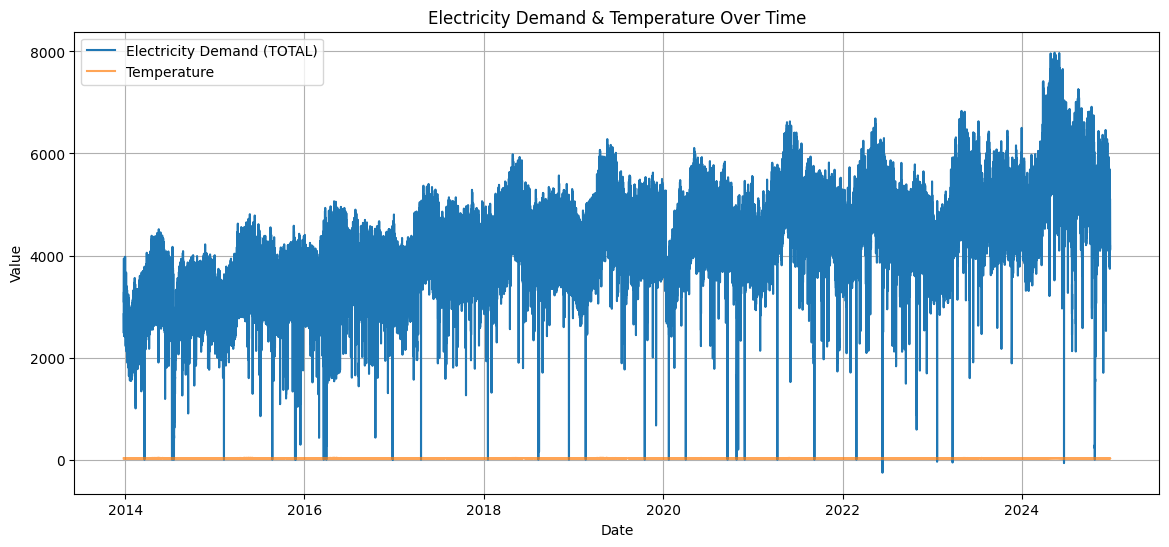

In [2]:
# Plot the new data to see if the noises were fixed using kalman filter

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# File path
file_path = "Demand_smoothed_kalman.csv"
chunksize = 10_000  # Initial chunk size

with open(file_path) as f:
    total_rows = sum(1 for _ in f) - 1

# Load dataset with progress bar
chunks = []
with tqdm(total=total_rows, desc="Loading CSV", unit="rows") as pbar:
    for chunk in pd.read_csv(file_path, parse_dates=["DateTime"], index_col="DateTime", chunksize=chunksize):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)

# Plot Demand (TOTAL) and Temperature
plt.figure(figsize=(14,6))
plt.plot(df.index, df["TOTAL"], label="Electricity Demand (TOTAL)", color="tab:blue")
plt.plot(df.index, df["Temperature"], label="Temperature", color="tab:orange", alpha=0.7)
plt.title("Electricity Demand & Temperature Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

### Make Cyclical time features

In [ ]:
import pandas as pd
import numpy as np

# Example: load your CSV
df = pd.read_csv("tmp/Demand_smoothed_kalman.csv", parse_dates=["DateTime"])

# ---- Make cyclical time features ----
def add_cyclical_time_features(df, datetime_col="DateTime"):
    dt = df[datetime_col]

    # Hour of day (0–23)
    df["hod_sin"] = np.sin(2 * np.pi * dt.dt.hour / 24)
    df["hod_cos"] = np.cos(2 * np.pi * dt.dt.hour / 24)

    # Day of week (0–6)
    df["dow_sin"] = np.sin(2 * np.pi * dt.dt.dayofweek / 7)
    df["dow_cos"] = np.cos(2 * np.pi * dt.dt.dayofweek / 7)

    # Day of month (0–31)
    # df["dom_sin"] = np.sin(2 * np.pi * dt.dt.dayofyear / 31)
    # df["dom_cos"] = np.cos(2 * np.pi * dt.dt.dayofyear / 31)
    
    # Day of year (0–365)
    df["doy_sin"] = np.sin(2 * np.pi * dt.dt.dayofyear / 365)
    df["doy_cos"] = np.cos(2 * np.pi * dt.dt.dayofyear / 365)

    return df

# Apply function
df = add_cyclical_time_features(df)

# Quick check
print(df.head())

df.to_csv("tmp/Demand_smoothed_kalman_with_time_features.csv", index=False)


             DateTime        TOTAL  Outage  Monday  Tuesday  Wednesday  \
0 2013-12-26 01:00:00  2850.352704       0       0        0          0   
1 2013-12-26 01:05:00  2834.879532       0       0        0          0   
2 2013-12-26 01:10:00  2822.299915       0       0        0          0   
3 2013-12-26 01:15:00  2810.543185       0       0        0          0   
4 2013-12-26 01:20:00  2799.491773       0       0        0          0   

   Thursday  Friday  Saturday  Sunday  ...  ALERT LEVEL 1  ALERT LEVEL 2  \
0         1       0         0       0  ...              0              0   
1         1       0         0       0  ...              0              0   
2         1       0         0       0  ...              0              0   
3         1       0         0       0  ...              0              0   
4         1       0         0       0  ...              0              0   

   ALERT LEVEL 3  Temperature   hod_sin   hod_cos   dow_sin   dow_cos  \
0              0    24.95

In [25]:
# Collapse ALERT LEVEL columns into one

import pandas as pd

# Load your CSV
df = pd.read_csv("tmp/Demand_smoothed_kalman_with_time_features.csv")

# Collapse ALERT LEVEL columns into one
df["ALERT_LEVEL"] = (
      df["ALERT LEVEL 1"] * 1
    + df["ALERT LEVEL 2"] * 2
    + df["ALERT LEVEL 3"] * 3
)

# Drop the old columns
df = df.drop(columns=["ALERT LEVEL 1", "ALERT LEVEL 2", "ALERT LEVEL 3"])

# print(df.loc[df["Alert_Level"] == 1, "DateTime"].head(1).to_list())

# Save back to CSV
df.to_csv("tmp/alert_collapsed.csv", index=False)

print("Dandadan!")


Dandadan!


In [ ]:
## Dont run this code

# import pandas as pd

# # Load main dataset
# df = pd.read_csv("tmp/alert_collapsed.csv", parse_dates=["DateTime"])

# # Load outage intervals
# outages = pd.read_csv("tmp/Outage_Runs.csv", parse_dates=["start", "end"])

# # Make sure Outage column exists
# if "Outage" not in df.columns:
#     df["Outage"] = 0

# # Mark outages
# for _, row in outages.iterrows():
#     mask = (df["DateTime"] >= row["start"]) & (df["DateTime"] <= row["end"])
#     df.loc[mask, "Outage"] = 1

# # Save updated dataset
# df.to_csv("modified_outage.csv", index=False)

# print("DONE!?!?!?!?")


DONE!?!?!?!?


### n

### Prepare data for price, solar, and wind

In [17]:
import pandas as pd

# Load your dataset (replace with actual path)
df = pd.read_csv("Dataset/final_data/nasapower_final_5min.csv")

# Ensure DATETIME is parsed as datetime
df["DATETIME"] = pd.to_datetime(df["DATETIME"])

# # Create new time-based features
# df["HOUR_OF_DAY"] = df['DATETIME'].dt.hour
# df["DAY_OF_YEAR"] = df["DATETIME"].dt.dayofyear
# df["MONTH_OF_YEAR"] = df["DATETIME"].dt.month

# The selected columns came from the paper in the objective 1. Just select the needed columns for each problem
# Price = 
# Solar = DATETIME, ALLSKY_SFC_SW_DWN (Target), HOUR_OF_DAY, DAY_OF_YEAR, SZA, CLOUD_AMT, AOD_55, T2M, RH2M, WS50M, PS, PRECTOTCORR
# Wind =  DATETIME, WS50M, HOUR_OF_DAY, MONTH_OF YEAR, DAY_OF_YEAR, WD50M, PS, RH2M, T2MDEW
selected_cols = [
    "DATETIME",
    "WS50M",
    # "HOUR_OF_DAY",
    # "MONTH_OF_YEAR",
    # "DAY_OF_YEAR",
    "WD50M",
    "PS",
    "RH2M",
    "T2M",
    "RH2M",
    "T2MDEW"
]

df_selected = df[selected_cols]

# Save the cleaned dataset
df_selected.to_csv("Dataset/Wind/wind_forecasting.csv", index=False)

print(df_selected.head())


             DATETIME     WS50M      WD50M         PS       RH2M        T2M  \
0 2014-01-01 00:00:00  5.729706  54.679412  99.957941  92.064412  23.122941   
1 2014-01-01 00:05:00  5.720515  54.968627  99.955588  92.118554  23.104583   
2 2014-01-01 00:10:00  5.711324  55.257843  99.953235  92.172696  23.086225   
3 2014-01-01 00:15:00  5.702132  55.547059  99.950882  92.226838  23.067868   
4 2014-01-01 00:20:00  5.692941  55.836275  99.948529  92.280980  23.049510   

        RH2M     T2MDEW  
0  92.064412  21.739412  
1  92.118554  21.731275  
2  92.172696  21.723137  
3  92.226838  21.715000  
4  92.280980  21.706863  


In [ ]:
import pandas as pd

# Load the full dataset
sample_df = pd.read_csv("Dataset/Wind/wind_forecasting.csv", parse_dates=["DATETIME"])

# Define cutoff
start = pd.Timestamp("2023-01-01")

# Extract rows starting from "start"
sample_df = sample_df[sample_df["DATETIME"] >= start]

sample_df.to_csv("Dataset/Wind/sample_wind_forecasting.csv", index=False)


### End